#Market Basket Analysis

A market basket analysis uses asosciation rule mining to find out what products or product categories are frequently purchased in the same basket or in subsequent baskets. This is useful for developing rules to automatically recommend products to customers based on items in their current basket or their previous transactions.

The data used in this notebook is the Instacart Online Grocery Shopping Dataset 2017 (Instacart, 2017). Guidance on using the mlxtend library for association rule mining came from reference to Moffet (2017) and Wong (2018).

##1. Prepare notebook

Prepare the notebook by importing these packages:
* <code>pandas</code> -- for dataframes
* <code>matplotlib</code> -- for plotting
* <code>seaborn</code>-- for plotting
* <code>numpy</code> -- for creating series where helpful for plotting
* <code>mlxtend</code> -- for association rule mining
* <code>gc</code> -- for manual garbage collection to manage memory use
* <code>drive</code> from <code>google.colab</code> -- read data from Google Drive

After importing the packages, the notebook is connected to my Google Drive where I have put the data. A set of functions are defined at the start. This allows subsequent cells to call the functions and thus less code is put between the exciting parts of the notebook.

In [0]:
# Import pandas for storing data in dataframes
import pandas as pd

# Import matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Enable seaborn format
sns.set()

# Nice to have in Jupyter Notebooks
%matplotlib inline 

# Import numpy for its help to create plots
import numpy as np

# Import mlxtend for association rule mining functions
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

# For manual garbage collection
import gc

# Allow display to show all columns
pd.options.display.max_columns = None

In [0]:
# Import Drive helper and mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# List the available files
ls '/content/drive/My Drive/Colab Notebooks/Data/Instacart May 2017/'

 aisles.csv              departments.csv             orders.csv
 Citation.txt            order_products__prior.csv   products.csv
'Data dictionary.docx'   order_products__train.csv


###Functions used in this notebook

This notebook is set up with some functions so that after this large cell, subsequent cells contain less code.
  
  1. <code>loadFile</code> -- Load the csv files into dataframes
  2. <code>joinNamesToOrderProducts</code> -- Join dataframes to get product name, aisle name, and department name for each product in each order
  3. <code>plotMostPopular</code> --  Produce a plot of the most popular product categories by how many times they are bought
  4. <code>prepareDataframe</code> -- Prepare the dataframe for association rule mining

In [0]:
# Functions used in this notebook

def loadFile(path, filename):
  """
  Load text file to pandas dataframe using default pd.read_csv settings, then print schema.
  
  :param path: path to folder where file is located
  :param filename: name of the file to load
  :returns: pandas dataframe of loaded text file
  """
  df = pd.read_csv(path + filename)
  print(' ')
  print(f'Loaded {filename}')
  print(df.info())
  return df


def joinNamesToOrderProducts(orderProducts, products, aisles, departments, orders):
  """
  Merge products, aisles, and departments to orderProducts, then select name columns.
  
  :param orderProducts: the order vs products dataframe
  :param products: the products dataframe
  :param aisles: the aisles dataframe
  :param department: the departments dataframe
  :param orders: the orders dataframe
  :returns: dataframe of orderProducts with names
  """
  orderProductsWithNames = orderProducts \
  .merge(products, how='inner', on='product_id') \
  .merge(aisles, how='inner', on='aisle_id') \
  .merge(departments, how='inner', on='department_id') \
  .merge(orders, how='inner', on='order_id') \
  [['order_id', 'product_name', 'aisle', 'department']]
  print(' ')
  print('Added names to order vs products')
  print(orderProductsWithNames.info())
  return orderProductsWithNames


def plotMostPopular(df, groupByCol, topX):
  """
  Plot the top X most popular products or product categories
  
  :param df: Input dataframe
  :param groupByCol: Column to group by for counting
  :param topX: Number of top values to show in plot
  :returns: None
  """
  # Set style so that text can be read against a dark background
  sns.set_style('darkgrid')
  
  # Make the plot
  sns.countplot(x = groupByCol, \
                data = df, \
                order = df[groupByCol].value_counts().iloc[:topX].index)
  
  # Rotate the x-axis labels so they do not overlap with each other
  plt.xticks(rotation=90)
  return None


def prepareDataframe(orderProductsWithNames, groupByCol):
  """
  Transpose and ecode orderProductsWithNames for market basket analysis
  
  :param orderProductsWithNames: the orderProductsWithNames dataframe
  :param groupByCol: Column to group by for counting
  :returns: transposed and encoded dataframe
  """
  
  # Attach count column
  df = orderProductsWithNames\
  .groupby(['order_id', groupByCol])\
  .size()\
  .reset_index(name='count')
  
  # Transpose the dataframe so each row is one order
  # and the product categories are the columns
  basket = df \
  .groupby(['order_id', groupByCol])['count'] \
  .sum() \
  .unstack() \
  .reset_index() \
  .fillna(0) \
  .set_index('order_id')
  
  # Apply encoding
  basketSets = basket.applymap(lambda x: 1 if x >= 1 else 0)
  
  return basketSets


##2. Load and prepare data

There are 5 files to load:
* aisles.csv -- lookup for name of each aisle ID
* departments.csv -- lookup for name of each department ID
* order_products__prior.csv -- products in each order, for the "prior" data set to extract insights for making predictions
* products.csv -- lookup for name of each product ID
* orders.csv -- the history or orders

The orders data is filtered to retain only the "prior" orders. This will prevent leakage of future data affecting the any predictions that may be made. There are also orders labelled as "train" and "test". These orders are made after the "prior" orders. A sample of 100,000 "prior" orders is used so that later processes do not exceed the notebook's RAM.

The filtered orders data is joined with the aisle, departments, products, and order vs products data sets to get the names of the products, aisles, and departments. The resultant dataframe takes up a large amount of RAM because strings (the data type of the names) take up a lot more space than numbers (the data type of the IDs). In a production process, this should be avoided. This analysis takes this step so that results show names, which are easier to understand than IDs.

In [0]:
# Define path to the folder containing the files
path = '/content/drive/My Drive/Colab Notebooks/Data/Instacart May 2017/'

# Load the files and show their schema
### Notes
# orders[orders['eval_set']=='prior']['order_id'].nunique() = 3214874
aisles = loadFile(path, 'aisles.csv')
departments = loadFile(path, 'departments.csv')
orderProducts = loadFile(path, 'order_products__prior.csv')
products = loadFile(path, 'products.csv')
orders = loadFile(path, 'orders.csv') 

# Filter orders to retain only the prior transactions
# Keep a sample to reduce memory load
ordersPrior = orders[orders['eval_set']=='prior']\
.sample(100000, random_state=38)
print(' ')
print('ordersPrior - prior orders only')
print(ordersPrior.info())

# Join dataframes to get names of product, aisle, and department
orderProductsWithNames = joinNamesToOrderProducts(orderProducts, products, aisles, departments, orders)

# Remove large dataframes from memory
del orders
del orderProducts
gc.collect()

 
Loaded aisles.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None
 
Loaded departments.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes
None
 
Loaded order_products__prior.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB
None
 
Loaded products.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-nul

88

##3. Select product category and plot most popular categories

There are 3 levels available for association rule mining. The most granular level is the product level with 49,688 distinct values. The next most granular level is the aisle level with 134 distinct values. The last and least granular level is the department level with 21 distinct values.

Using the most granular level allows the most specific associations to be found. However, the large number of values will significantly increase the computation cost because the number of combinations increases superlinearly with the number of values. On the other extreme, using the least granular level will result in the lowest computation cost at the expense of less specific associations. In this notebook, the middle ground of the aisle level is used.

A plot is made of the most popular aisles. The popularity is defined by the number of products ordered from that aisle. For example, if an order has 2 products from the same aisle, that will count as 2. This is useful to check that the found association rules make sense because a popular aisle is very likely to have an association with another aisle. If the most popular aisles do not appear in the discovered association rules, then something is likely wrong in the analysis.

In [0]:
# Choose the product category
#prodCatLevel = 'department'
prodCatLevel = 'aisle'
#prodCatLevel = 'product'

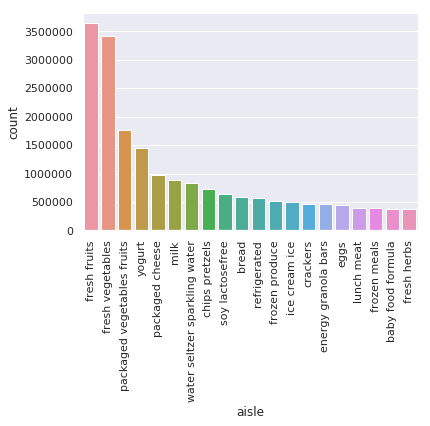

In [0]:
# Plot most popular categories
plotMostPopular(orderProductsWithNames, prodCatLevel, 20)

## 4. Association rule mining

Each row in the dataframe of orders vs products is a combination of an order and a product included in that order. 
This means that an order ID will appear in multiple rows. 
The <code>mlxtend</code> association rule mining functions require each order to occupy only one row, and thus the columns are the product categories.
If one or more item from a product category is bought in an order, then a "1" is put in the cell for that order (row) and product (column).
Otherwise, the value is "0".
Due to this requirement, the order vs products dataframe must first be transposed and have values transformed so that it complies with the format required by <code>mlxtend</code>.

After the dataframe has been prepared, the first step in association rule mining is to calculate the support for combinations of multiple product categories by using the <code>apriori</code> fuction. 
The support is the fraction of orders that contain the combination of product categories. 
A minimum support threshold is defined so that further analysis ignores products or product categories that are rarely bought.

A maximum combination of product categories is also defined.
If the value is set to 1, then the function will only calculate support for individual product categories.
Finding association rules requires having support for a combination of 2 or more product categories, therefore the value must be set to 2 or greater.

The second step is to find the association rules. 
This step takes the product category combinations found in the first step and calculates additional metrics to evaluate whether the combination is useful as a rule or not.
One metric is confidence.
Confidence evaluates how often the second product category is bought, given that the first product category has been bought.
In other words, it is how often the rule is true when the condition is met to apply the rule.
The higher the confidence (maximum of 1), the more often the rule is true.

Another metric is lift.
Lift evaluates whether the combination of product categories is occurring because customers want to buy the product categories together, or because it is occuring at random.
If lift is 1, then the data suggests that the combination of product categories is occurring at random.
The higher the lift, the more likely the combination of product categories is due to customers wnating to buy the combination.

In [0]:
# Transpose the dataframe so each row is one order
# and the product categories are the columns
### Insufficient RAM to process 'aisle' or 'product' on all 3 million prior orders
basketSet = prepareDataframe(orderProductsWithNames, prodCatLevel)

In [0]:
# Find product categories frequently bought
# Define max_len to reduce memory load
itemSupport = apriori(basketSet, min_support=0.15, use_colnames=True, max_len=2)

# Find the association rules
rules = association_rules(itemSupport, metric='lift', min_threshold=1)

display(rules.sort_values(by='lift', ascending=False).head(20))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11,(packaged vegetables fruits),(fresh vegetables),0.366808,0.444071,0.234454,0.639173,1.439349,0.071565,1.540708
10,(fresh vegetables),(packaged vegetables fruits),0.444071,0.366808,0.234454,0.527966,1.439349,0.071565,1.341410
6,(fresh fruits),(packaged vegetables fruits),0.557027,0.366808,0.270270,0.485201,1.322763,0.065948,1.229977
7,(packaged vegetables fruits),(fresh fruits),0.366808,0.557027,0.270270,0.736814,1.322763,0.065948,1.683120
0,(fresh fruits),(fresh vegetables),0.557027,0.444071,0.317762,0.570460,1.284617,0.070403,1.294245
1,(fresh vegetables),(fresh fruits),0.444071,0.557027,0.317762,0.715566,1.284617,0.070403,1.557384
8,(fresh fruits),(yogurt),0.557027,0.263488,0.188071,0.337633,1.281399,0.041301,1.111940
9,(yogurt),(fresh fruits),0.263488,0.557027,0.188071,0.713774,1.281399,0.041301,1.547632
4,(fresh fruits),(packaged cheese),0.557027,0.229527,0.154977,0.278222,1.212154,0.027124,1.067465
5,(packaged cheese),(fresh fruits),0.229527,0.557027,0.154977,0.675202,1.212154,0.027124,1.363843


## 5. Results discussion

The results show that there are 6 pairs of product categories that satisfy the requirements of support at least 0.15 and lift at least 1. The category "fresh fruits" is in 5 of the 6 pairs, which makes sense because "fresh fruits" is the most popular product category by the total number of products ordered from the category.

According to these results, if a customer put "fresh fruits" in their basket, they are likely to also want "packaged vegetables fruits", "fresh vegetables", "yogurt", "packaged cheese", or "milk". The "packaged vegetables fruits" and "fresh vegetables" are also likely to be put in the same basket.

More association rules could be found by lowering the minimum support threshold. The trade-off will be that the additional discovered associations will be those that appear less frequently in the data.

New insights could also be found by increasing the maximum number of product categories to include in an association rule. For example, if the parameter max_len was increased to 3, then it would be possible to reveal association rules such as order "fresh fruit" given that ordered "packaged vegetable fruits" and "fresh vegetables".


## 6. References

“The Instacart Online Grocery Shopping Dataset 2017”, accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on 10 June 2019

Wong, George 2018, *MBA for Breakfast - A Simple Guide to Market Basket Analysis*, accessed from https://towardsdatascience.com/mba-for-breakfast-4c18164ef82b

Moffitt, Chris 2017, *Introduction to Market Basket Analysis in Python*, accessed from https://pbpython.com/market-basket-analysis.html